In [24]:
import gymnasium
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio
import pandas as pd
from tabulate import tabulate

In [2]:
env = gymnasium.make('MountainCar-v0', max_episode_steps=1000, render_mode="rgb_array")

In [3]:
# selecting a uniform discretization step (∆)
def get_bins(n_discrete_steps):
    position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_discrete_steps)
    velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_discrete_steps)
    return position_bins, velocity_bins

In [4]:
# preprocess continuous states into discrete states
def discretize_state(state, position_space, velocity_space):
    position_idx = np.digitize(state[0], position_space) - 1
    velocity_idx = np.digitize(state[1], velocity_space) - 1
    return position_idx, velocity_idx

In [5]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [6]:
def eps_greedy_policy(Q, epsilon, action_space):
    # define an epsilon-greedy policy function based on Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [7]:
def q_learning(env, n_discrete_steps, num_episodes=20000, alpha=0.1, gamma=0.99,
               epsilon_start=1.0, epsilon_decay_rate=0.9999, epsilon_min=0.01, render=False):
    position_bins, velocity_bins = get_bins(n_discrete_steps)

    Q = np.zeros((n_discrete_steps, n_discrete_steps, env.action_space.n))

    # initialize policy using epsilon-greedy method
    epsilon = epsilon_start
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": [],
             "episode_reward": [],
             "successes": []}

    for episode in range(1, num_episodes + 1):
        if episode % 100 == 0:
            print(f"\rEpisode {episode}/{num_episodes}.", end="")

        state = discretize_state(env.reset()[0], position_bins, velocity_bins)
        episode_length, episode_reward = 0, 0
        success = 0  # track success for the current episode

        # frames = []

        while True:
            probs = policy(state)
            # choose A from S using eps-greedy policy derived from Q
            action = np.random.choice(np.arange(len(probs)), p=probs)

            next_state, reward, done, truncated, _ = env.step(action)
            next_state_discrete = discretize_state(next_state, position_bins, velocity_bins)

            # if render and episode == num_episodes:
            #     frame = env.render()
            #     frames.append(frame)

            td_target = reward + gamma * np.max(Q[next_state_discrete])
            Q[state + (action,)] += alpha * (td_target - Q[state + (action,)])

            episode_length += 1
            episode_reward += reward

            if done or truncated:
                stats["episode_length"].append(episode_length)
                stats["episode_reward"].append(episode_reward)

                # if the episode ended because the goal was reached (done=True) and not truncated, mark as success
                if done and not truncated:
                    success = 1
                stats["successes"].append(success)
                break

            state = next_state_discrete

        # if render and episode == num_episodes:
        #     imageio.mimsave(f'{n_discrete_steps}s.gif', frames, fps=40)

        epsilon = max(epsilon_min, epsilon_decay_rate * epsilon)
        policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    return Q, stats

In [8]:
Q_5, stats_5 = q_learning(env, n_discrete_steps=5)

Episode 20000/20000.

In [9]:
Q_10, stats_10 = q_learning(env, n_discrete_steps=10)

Episode 20000/20000.

In [10]:
Q_20, stats_20 = q_learning(env, n_discrete_steps=20)

Episode 20000/20000.

In [11]:
Q_40, stats_40 = q_learning(env, n_discrete_steps=40)

Episode 20000/20000.

In [82]:
Q_80, stats_80 = q_learning(env, n_discrete_steps=80)

Episode 20000/20000.

In [20]:
discretization_levels = [5, 10, 20, 40]

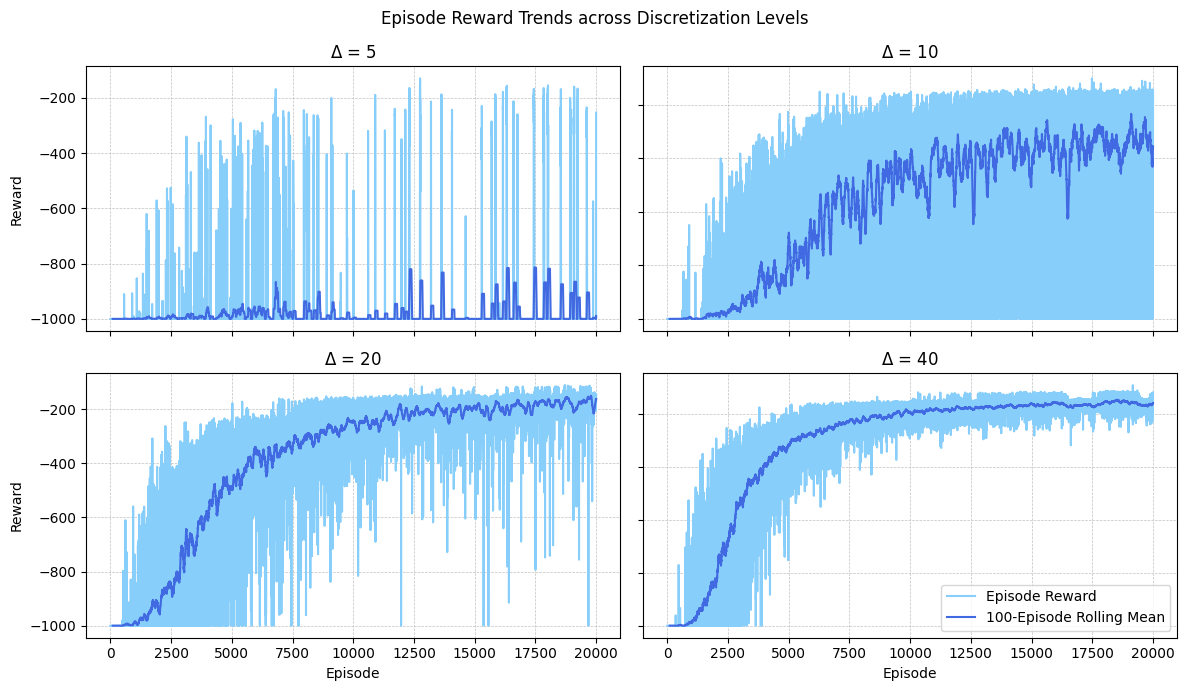

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle('Episode Reward Trends across Discretization Levels')

for i, (n_discrete_steps, stats) in enumerate(zip(discretization_levels, [stats_5, stats_10, stats_20, stats_40])):
    ax = axes[i // 2, i % 2]

    episode_rolling_mean = pd.Series(stats["episode_reward"]).rolling(100).mean()
    ax.plot(stats["episode_reward"], color="lightskyblue", label="Episode Reward")
    ax.plot(episode_rolling_mean, color="royalblue", label="100-Episode Rolling Mean")

    ax.set_title(f'$\Delta$ = {n_discrete_steps}')
    ax.grid(color='silver', linestyle='--', linewidth=0.5)

for ax in axes.flat:
    ax.set(xlabel='Episode', ylabel='Reward')
    ax.label_outer()

plt.legend()
plt.tight_layout()
plt.show()

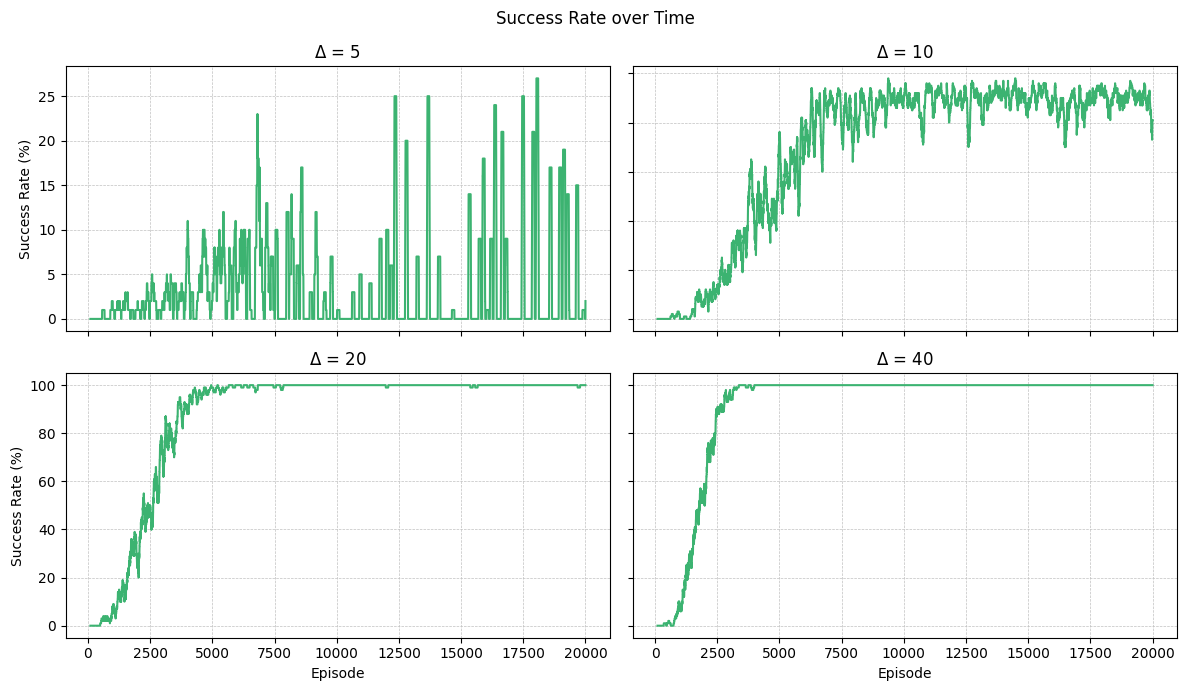

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle('Success Rate over Time')

for i, (n_discrete_steps, stats) in enumerate(zip(discretization_levels, [stats_5, stats_10, stats_20, stats_40])):
    ax = axes[i // 2, i % 2]

    success_rate_over_time = pd.Series(stats["successes"]).rolling(100).mean() * 100
    ax.plot(success_rate_over_time, color="mediumseagreen")
    
    ax.set_title(f'$\Delta$ = {n_discrete_steps}')
    ax.grid(color='silver', linestyle='--', linewidth=0.5)

for ax in axes.flat:
    ax.set(xlabel='Episode', ylabel='Success Rate (%)')
    ax.label_outer()

plt.tight_layout()
plt.show()

In [99]:
results = []

for n_discrete_steps, stats in zip(discretization_levels, [stats_5, stats_10, stats_20, stats_40]):
    average_reward = np.mean(stats["episode_reward"])
    success_rate = (sum(stats["successes"]) / len(stats["successes"])) * 100

    # calculate the average length of successful episodes
    successful_lengths = [length for length, success in zip(stats["episode_length"], stats["successes"]) if success]
    average_success_length = np.mean(successful_lengths)

    results.append([n_discrete_steps, average_reward, success_rate, average_success_length])

headers = ["Discretization Level (∆)", "Average Episode Reward", "Success Rate (%)", "Average Length of Success"]
print(tabulate(results, headers=headers, tablefmt="simple"))  # numalign="center"

  Discretization Level (∆)    Average Episode Reward    Success Rate (%)    Average Length of Success
--------------------------  ------------------------  ------------------  ---------------------------
                         5                  -981.065                3.54                      465.107
                        10                  -572.424               69.74                      386.9
                        20                  -384.148               87.58                      296.812
                        40                  -311.284               91.04                      243.502
